First i will install and import all important libraries 

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline

import folium # map rendering library

print('Libraries imported.')

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.8.3
  latest version: 4.8.4

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-2.0.0                |     pyh9f0ad1d_0          63 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-2.0.0

Extract data from newyork_data.json

In [2]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [3]:
neighborhoods_data = newyork_data['features']

In [4]:
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

Convert json to dataframe

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [6]:
neighborhoods

,Borough,Neighborhood,Latitude,Longitude


In [7]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

Let's see the example of the data.

In [8]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:


print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)



The dataframe has 5 boroughs and 306 neighborhoods.


Then, extract Turkish restuarants data from Foursquare API.

In [10]:
def get_venues(lat,lng):
    
    #set variables
    CLIENT_ID = 'OWKYWQK2WB2FBHRQ4SGCRXSFPLPHT1IZJAX5X1PGWZUO24HG' # your Foursquare ID
    CLIENT_SECRET = 'MA4HG33KSVVCZDZ3AM13DDNJSHN23OH5C4KTRGOZAGF1IZUT' # your Foursquare Secret
    VERSION = '20200901' # Foursquare API version
    LIMIT = 500
    radius = 500
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [13]:
# prepare neighborhood list that contains Turkish Restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
turk_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in neighborhoods.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    turk_resturants=venues[venues['Category']=='Turkish Restaurant']   
    print('(',count,'/',len(neighborhoods),')','Turkish Restaurants in '+Neighborhood+', '+Borough+':'+str(len(turk_resturants)))
    for resturant_detail in turk_resturants.values.tolist():
        id, name , category=resturant_detail
        turk_rest_ny = turk_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1


( 1 / 306 ) Turkish Restaurants in Wakefield, Bronx:0
( 2 / 306 ) Turkish Restaurants in Co-op City, Bronx:0
( 3 / 306 ) Turkish Restaurants in Eastchester, Bronx:0
( 4 / 306 ) Turkish Restaurants in Fieldston, Bronx:0
( 5 / 306 ) Turkish Restaurants in Riverdale, Bronx:0
( 6 / 306 ) Turkish Restaurants in Kingsbridge, Bronx:0
( 7 / 306 ) Turkish Restaurants in Marble Hill, Manhattan:0
( 8 / 306 ) Turkish Restaurants in Woodlawn, Bronx:0
( 9 / 306 ) Turkish Restaurants in Norwood, Bronx:0
( 10 / 306 ) Turkish Restaurants in Williamsbridge, Bronx:0
( 11 / 306 ) Turkish Restaurants in Baychester, Bronx:0
( 12 / 306 ) Turkish Restaurants in Pelham Parkway, Bronx:0
( 13 / 306 ) Turkish Restaurants in City Island, Bronx:0
( 14 / 306 ) Turkish Restaurants in Bedford Park, Bronx:0
( 15 / 306 ) Turkish Restaurants in University Heights, Bronx:0
( 16 / 306 ) Turkish Restaurants in Morris Heights, Bronx:0
( 17 / 306 ) Turkish Restaurants in Fordham, Bronx:0
( 18 / 306 ) Turkish Restaurants in Ea

In [14]:
turk_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Brooklyn,Bay Ridge,579d3e7c498effa33c0450af,Istanbul Bay
1,Brooklyn,Gravesend,51a2a2a3498e0d5d337f137b,Wood Spoon
2,Brooklyn,Sheepshead Bay,4fcbfc92e4b088c92e7e97ad,Opera Cafe Lounge
3,Brooklyn,Sheepshead Bay,4b1d5405f964a520d70e24e3,Liman Restaurant
4,Brooklyn,Manhattan Terrace,4a060d32f964a520b1721fe3,Taci's Beyti Restaurant


In [15]:
turk_rest_ny.shape

(22, 4)

Keep data into csv to prevent API limit.

In [16]:
turk_rest_ny.to_csv('turk_rest_ny.csv', index=False)

In [17]:
turk_rest_ny_csv = pd.read_csv('turk_rest_ny.csv')


In [18]:
turk_rest_ny_csv.head()

,Borough,Neighborhood,ID,Name
0,Brooklyn,Bay Ridge,579d3e7c498effa33c0450af,Istanbul Bay
1,Brooklyn,Gravesend,51a2a2a3498e0d5d337f137b,Wood Spoon
2,Brooklyn,Sheepshead Bay,4fcbfc92e4b088c92e7e97ad,Opera Cafe Lounge
3,Brooklyn,Sheepshead Bay,4b1d5405f964a520d70e24e3,Liman Restaurant
4,Brooklyn,Manhattan Terrace,4a060d32f964a520b1721fe3,Taci's Beyti Restaurant


In [19]:
turk_rest_ny_csv.shape

(22, 4)

Let's see which borough has the most Turkish restaurants.

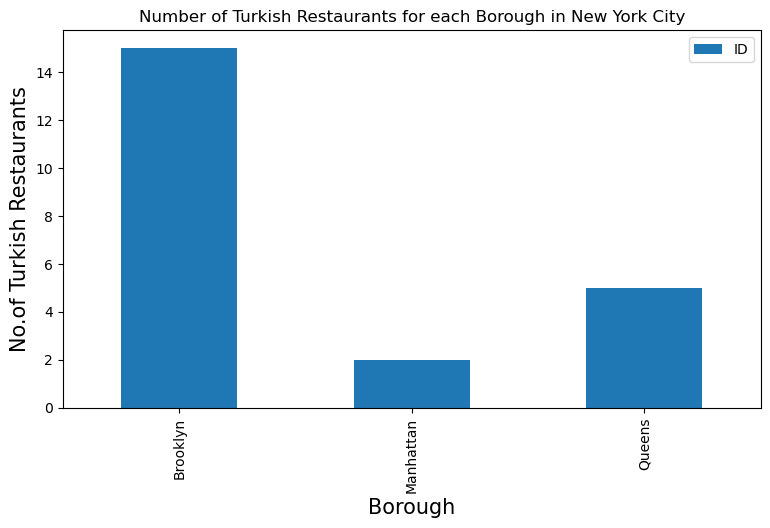

In [20]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Turkish Restaurants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No.of Turkish Restaurants', fontsize=15)
#giving a bar plot
turk_rest_ny_csv.groupby('Borough')['ID'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

We found that Manhattan has the most Turkish restaurants in New York City. Then let's see which neighborhood has the most Turkish restaurants.

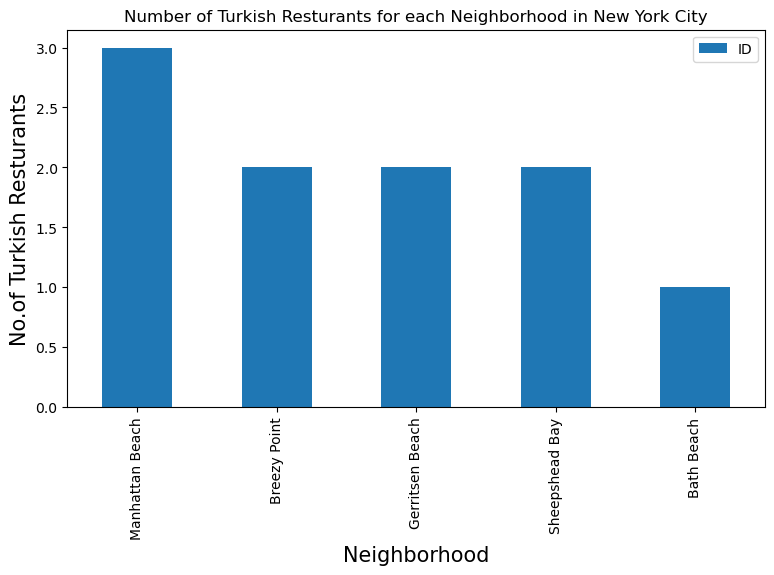

In [21]:

plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Turkish Resturants for each Neighborhood in New York City')
#On x-axis
plt.xlabel('Neighborhood', fontsize = 15)
#On y-axis
plt.ylabel('No.of Turkish Resturants', fontsize=15)
#giving a bar plot
turk_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

In [22]:
turk_rest_ny_csv[turk_rest_ny_csv['Neighborhood']=='Manhattan Beach']

,Borough,Neighborhood,ID,Name
5,Brooklyn,Manhattan Beach,4b1d5405f964a520d70e24e3,Liman Restaurant
6,Brooklyn,Manhattan Beach,4fcbfc92e4b088c92e7e97ad,Opera Cafe Lounge
7,Brooklyn,Manhattan Beach,4a986cf5f964a520f32b20e3,Istanbul Restaurant Fish & Kebab


Let's get more insight on each restaurant (Rating, Tips, Like) from Foursquare API.

In [23]:
def get_venue_details(venue_id):
    #set variables
    CLIENT_ID = 'OWKYWQK2WB2FBHRQ4SGCRXSFPLPHT1IZJAX5X1PGWZUO24HG' # your Foursquare ID
    CLIENT_SECRET = 'MA4HG33KSVVCZDZ3AM13DDNJSHN23OH5C4KTRGOZAGF1IZUT' # your Foursquare Secret
    VERSION = '20200901' # Foursquare API version
    
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [24]:
# prepare neighborhood list that contains indian resturants
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
turk_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in turk_rest_ny_csv.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(turk_rest_ny_csv),')','processed')
    turk_rest_stats_ny = turk_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID          Name  Likes  Rating  Tips
0  579d3e7c498effa33c0450af  Istanbul Bay     23     8.2     4
( 1 / 22 ) processed
                         ID        Name  Likes  Rating  Tips
0  51a2a2a3498e0d5d337f137b  Wood Spoon      5     7.2     3
( 2 / 22 ) processed
                         ID               Name  Likes  Rating  Tips
0  4fcbfc92e4b088c92e7e97ad  Opera Cafe Lounge    256     8.2    54
( 3 / 22 ) processed
                         ID              Name  Likes  Rating  Tips
0  4b1d5405f964a520d70e24e3  Liman Restaurant     98     8.4    38
( 4 / 22 ) processed
                         ID                     Name  Likes  Rating  Tips
0  4a060d32f964a520b1721fe3  Taci's Beyti Restaurant    249     8.7    68
( 5 / 22 ) processed
                         ID              Name  Likes  Rating  Tips
0  4b1d5405f964a520d70e24e3  Liman Restaurant     98     8.4    38
( 6 / 22 ) processed
                         ID               Name  Likes  Rating  Tips
0  4fc

In [25]:
turk_rest_stats_ny.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Brooklyn,Bay Ridge,579d3e7c498effa33c0450af,Istanbul Bay,23,8.2,4
1,Brooklyn,Gravesend,51a2a2a3498e0d5d337f137b,Wood Spoon,5,7.2,3
2,Brooklyn,Sheepshead Bay,4fcbfc92e4b088c92e7e97ad,Opera Cafe Lounge,256,8.2,54
3,Brooklyn,Sheepshead Bay,4b1d5405f964a520d70e24e3,Liman Restaurant,98,8.4,38
4,Brooklyn,Manhattan Terrace,4a060d32f964a520b1721fe3,Taci's Beyti Restaurant,249,8.7,68


In [26]:
turk_rest_stats_ny.shape

(22, 7)

In [27]:
turk_rest_stats_ny.to_csv('turk_rest_stats_ny.csv', index=False)

In [28]:
turk_rest_stats_ny_csv=pd.read_csv('turk_rest_stats_ny.csv')


In [29]:
turk_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Brooklyn,Bay Ridge,579d3e7c498effa33c0450af,Istanbul Bay,23,8.2,4
1,Brooklyn,Gravesend,51a2a2a3498e0d5d337f137b,Wood Spoon,5,7.2,3
2,Brooklyn,Sheepshead Bay,4fcbfc92e4b088c92e7e97ad,Opera Cafe Lounge,256,8.2,54
3,Brooklyn,Sheepshead Bay,4b1d5405f964a520d70e24e3,Liman Restaurant,98,8.4,38
4,Brooklyn,Manhattan Terrace,4a060d32f964a520b1721fe3,Taci's Beyti Restaurant,249,8.7,68


In [30]:
turk_rest_stats_ny_csv.shape

(22, 7)

In [31]:
turk_rest_stats_ny_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       22 non-null     object 
 1   Neighborhood  22 non-null     object 
 2   ID            22 non-null     object 
 3   Name          22 non-null     object 
 4   Likes         22 non-null     int64  
 5   Rating        22 non-null     float64
 6   Tips          22 non-null     int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 1.3+ KB



Convert tips data type from string to float for easy to analyze.

In [32]:
turk_rest_stats_ny['Likes']=turk_rest_stats_ny['Likes'].astype('float64')
turk_rest_stats_ny['Tips']=turk_rest_stats_ny['Tips'].astype('float64')

In [33]:
turk_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22 entries, 0 to 21
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       22 non-null     object 
 1   Neighborhood  22 non-null     object 
 2   ID            22 non-null     object 
 3   Name          22 non-null     object 
 4   Likes         22 non-null     float64
 5   Rating        22 non-null     float64
 6   Tips          22 non-null     float64
dtypes: float64(3), object(4)
memory usage: 1.3+ KB



Restaurant with maximum Likes

In [34]:
# Restaurant with maximum Likes
turk_rest_stats_ny.iloc[turk_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                  Turtle Bay
ID              50fc9a88e4b04cfffaebe2cf
Name                             Sip Sak
Likes                                282
Rating                               8.8
Tips                                  99
Name: 17, dtype: object

Restaurant with maximum Rating

In [35]:
# Restaurant with maximum Rating
turk_rest_stats_ny.iloc[turk_rest_stats_ny['Rating'].idxmax()]

Borough                        Manhattan
Neighborhood                  Turtle Bay
ID              50fc9a88e4b04cfffaebe2cf
Name                             Sip Sak
Likes                                282
Rating                               8.8
Tips                                  99
Name: 17, dtype: object

In [36]:
turk_rest_stats_ny.iloc[turk_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                  Turtle Bay
ID              50fc9a88e4b04cfffaebe2cf
Name                             Sip Sak
Likes                                282
Rating                               8.8
Tips                                  99
Name: 17, dtype: object

Let's summarize average rating of Turkish restaurants in each neighborhood.


In [37]:
ny_neighborhood_stats=turk_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [38]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head()

,Neighborhood,Average Rating
15,Turtle Bay,8.8
6,Homecrest,8.7
7,Madison,8.7
9,Manhattan Terrace,8.7
10,Ocean Parkway,8.7


Let's summarize average rating of Turkish restuarants in each borough.

In [39]:
ny_borough_stats=turk_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [40]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
1,Manhattan,8.550000
2,Queens,8.340000
0,Brooklyn,8.233333


Visualize average rating of Turkish restuarants for each borough.

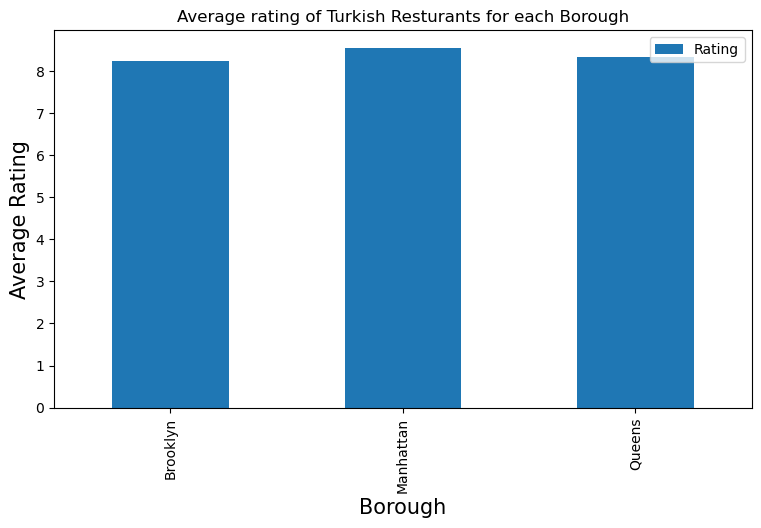

In [41]:
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Average rating of Turkish Resturants for each Borough')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('Average Rating', fontsize=15)
#giving a bar plot
turk_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()

Select only neighborhoods which average rating more than 8.5



In [42]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.5]
ny_neighborhood_stats

,Neighborhood,Average Rating
6,Homecrest,8.7
7,Madison,8.7
9,Manhattan Terrace,8.7
10,Ocean Parkway,8.7
11,Ravenswood,8.5
15,Turtle Bay,8.8


Merge high average rating neighborhoods with their latitude and longitude to visualize in map.



In [43]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,neighborhoods, on='Neighborhood')

In [44]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [45]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Brooklyn,Homecrest,40.598525,-73.959185,8.7
1,Brooklyn,Madison,40.609378,-73.948415,8.7
2,Brooklyn,Manhattan Terrace,40.614433,-73.957438,8.7
3,Brooklyn,Ocean Parkway,40.613060,-73.968367,8.7
4,Queens,Ravenswood,40.761705,-73.931575,8.5
5,Manhattan,Turtle Bay,40.752042,-73.967708,8.8


Visualize the location of each neighborhood which highest average rating in the map.

In [46]:


address='New York City, NY'
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude



In [47]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [48]:
# instantiate a feature group for the incidents in the dataframe
turk_res = folium.map.FeatureGroup()

# loop through the neighborhood and add each to the feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    turk_res.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [49]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [50]:
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add incidents to map
ny_map.add_child(turk_res)

Conclusion

as we can see the best place that has best rated Turkish restaurant in venu of Turtle Bay in manhattan , so this is the best place where this turkish torrist can locate